In [1]:
#import packages for plotting

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from Bandpass import butter_bandpass_filter
from Hilbert import Hilbert_transform,phase
from CoherenceMap import LeadingEigenVector

# Read all the early preprossed data

In [2]:
n = 215 #highest ID of face filename

notfound = {}
X = []

for i in range(n):
    try:
            df = pd.read_csv(f"AALdata/sub-{(i+1):04d}_faces.csv",sep=",",header=None)
    
    except FileNotFoundError:
        
            notfound[i] = f"{(i+1):04d}"
            continue
    X.append(df.values)

print(f"files not found {[*notfound.values()]}")
print(f"Number of files not found: {len(notfound)}")
print(f"Number of subjects {len(X)}")
print(f"Dimentions of data {(len(X),X[0].shape[0],X[0].shape[1])}")

files not found ['0022', '0023', '0032', '0068', '0072', '0073', '0086', '0089', '0106', '0107', '0144', '0152']
Number of files not found: 12
Number of subjects 203
Dimentions of data (203, 90, 330)


# Select some of the early preprossed data to plot

In [36]:
N = 5 # number of brain areas plotted
data_raw = X[0][0:N,:] #the N first brain areas for the 

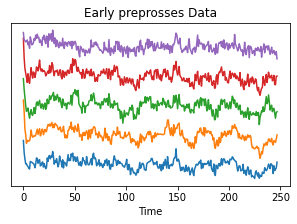

In [37]:
plt.figure(figsize=(5,3))
plt.title("Early preprosses Data")
plt.xlabel("Time")
plt.yticks([])

time = np.arange(0,330*3/4,3/4) #x axis for plots. 330 datapoints collected at a 3/4 frequency

for i in range(N):
    plt.plot(time,(data_raw[i,:] - np.mean(data_raw[i,:]) + 200 * i))
    #No y axis. The signals are plotted so they dont lay on top of eachother         
plt.show()

# Plot data after Bandpass filter

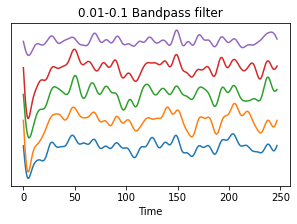

In [38]:
data_bandpass = butter_bandpass_filter(data_raw)

plt.figure(figsize=(5,3))
plt.title("0.01-0.1 Bandpass filter")
plt.xlabel("Time")
plt.yticks([])

for i in range(5):
    plt.plot(time,data_bandpass[i,:] + 130 * i)
    #No y axis. The signals are plotted so they dont lay on top of eachother
    
plt.show()

# Plot data after hilbert transformation

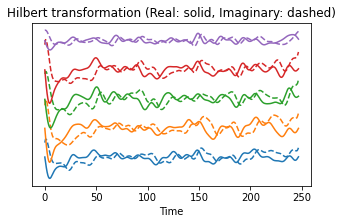

In [39]:
#list of colors used in plot
c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize=(5,3))
plt.yticks([])
plt.title("Hilbert transformation (Real: solid, Imaginary: dashed)")
plt.xlabel("Time")

S_t = []
SH_t = []

for i in range(5):
    s_t, sh_t = Hilbert_transform(data_bandpass[i,:])
    S_t.append(s_t)
    SH_t.append(sh_t)
    plt.plot(time,s_t + 220 * i, c[i] )
    plt.plot(time,sh_t + 220 * i, "--")
    #No y axis. The signals are plotted so they dont lay on top of eachother

plt.show()

# Phase extraction

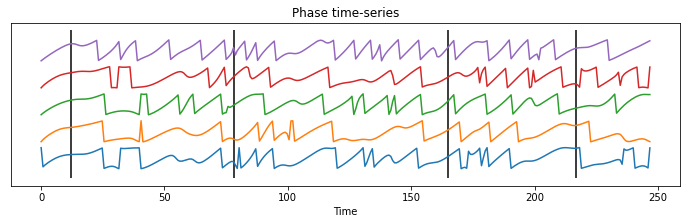

In [44]:
plt.figure(figsize=(12,3))
plt.yticks([])
plt.title("Phase time-series")
plt.xlabel("Time")

for i in range(5):
    theta_t = phase(S_t[i], SH_t[i])
    plt.plot(time,theta_t + 4 * i)
    #No y axis. The signals are plotted so they dont lay on top of eachother

timemarks = [12,78,165,217] #list of random timemarks to look at 
    
for i in range(len(timemarks)):
    plt.vlines(timemarks[i], -3, 19, linestyles ="solid", colors ="k")
    #plot timemarks

plt.show()

# Plot Coherence MAP

In [45]:
#modified version of the CoherenceMap function so it plots the CoherenceMaps

def CoherenceMap(Theta):
    N,T = Theta.shape
    
    LEiDA_Signal = np.zeros((N,T))

    At = np.zeros((N,N))

    for t in range(T):
        CurrentSample = Theta[:,t]
        for j in range(N):
            for k in range(N):
                At[j,k]=np.cos(CurrentSample[j]-CurrentSample[k])
                
        LEiDA_Signal[:,t] = LeadingEigenVector(At)
    
        if t in timemarks:
            plt.title(f"CoherenceMap for timestep {t} ")
            plt.imshow(At, interpolation='nearest')
            plt.colorbar()
            plt.show()
    
    return LEiDA_Signal

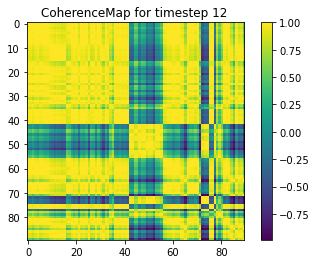

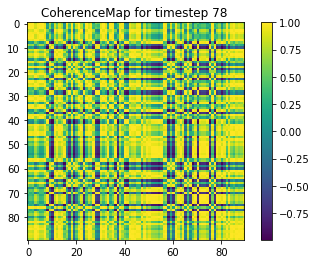

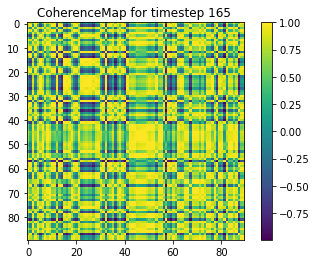

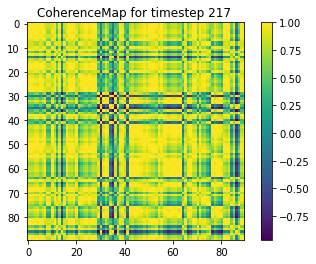

In [46]:
#filter(bandpass, hilbert, and phase) all 90 brain areas for the first subject
N,T = X[0].shape
X_filtered = np.zeros((N,T))

for idx, x in enumerate(X[0]):
    X_filtered[idx,:] = butter_bandpass_filter(x)

Theta = np.zeros((N,T))
for idx, x in enumerate(X_filtered):
    s_t,sh_t=Hilbert_transform(x)
    Theta_t = phase(s_t, sh_t)
    Theta[idx,:] = Theta_t

#Get LEdiDa signal for all 90 brainCoherenceMap
LEiDA_Signal = CoherenceMap(Theta)

# Plotting the Leading eigenvector for each coherance map

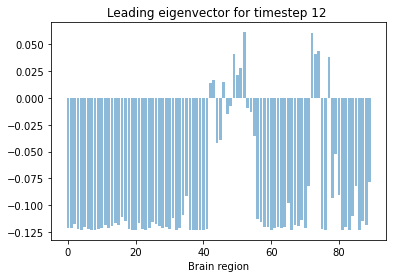

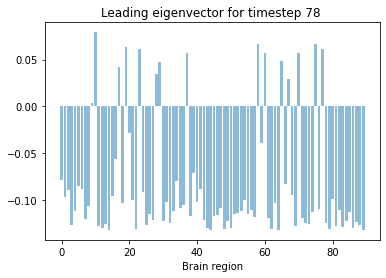

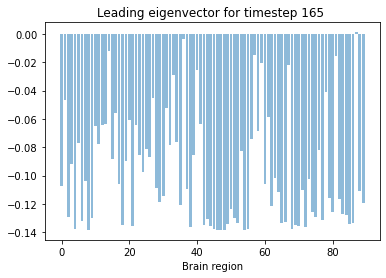

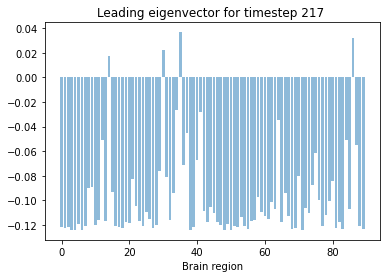

In [43]:
for t in timemarks:
    y_pos = np.arange(len(LEiDA_Signal[:,t])) 

    plt.title(f"Leading eigenvector for timestep {t} ")
    plt.bar(y_pos, LEiDA_Signal[:,t], align='center', alpha=0.5)
    plt.xlabel("Brain region")
    plt.show()

14